# **LOADING DATASET**

In [ ]:
import pandas as pd
pd.read_csv("emotions.csv")



,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [ ]:
df = pd.read_csv("emotions.csv")

print(df.head())

print(df.info())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB
None


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
print(df['label'].value_counts())


label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


# **Mapping label integers to emotions**

In [ ]:
label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
df['emotion'] = df['label'].map(label_map)


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess)


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])


In [ ]:
le = LabelEncoder()
y = le.fit_transform(df['emotion'])


In [ ]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label} ({le.classes_[label]}): {count} samples")


Label 0 (anger): 57317 samples
Label 1 (fear): 47712 samples
Label 2 (joy): 141067 samples
Label 3 (love): 34554 samples
Label 4 (sadness): 121187 samples
Label 5 (surprise): 14972 samples


# **label encoding and vectorization**


In [ ]:
df_filtered = df.copy()
emotion_counts = df_filtered['emotion'].value_counts()

valid_emotions = emotion_counts[emotion_counts >= 2].index
df_filtered = df_filtered[df_filtered['emotion'].isin(valid_emotions)]

y = le.fit_transform(df_filtered['emotion'])
X = vectorizer.fit_transform(df_filtered['clean_text'])


# **Training and testing**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# **Accuracy and classification report of Linear SVC**


Accuracy: 0.8980
              precision    recall  f1-score   support

       anger       0.90      0.90      0.90     11463
        fear       0.84      0.85      0.84      9542
         joy       0.92      0.93      0.92     28214
        love       0.80      0.78      0.79      6911
     sadness       0.94      0.94      0.94     24238
    surprise       0.73      0.71      0.72      2994

    accuracy                           0.90     83362
   macro avg       0.86      0.85      0.85     83362
weighted avg       0.90      0.90      0.90     83362



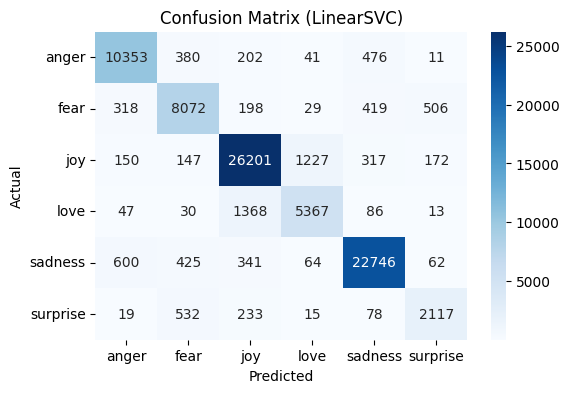

In [ ]:

from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (LinearSVC)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# **Example input and predicting of Linear SVC**


In [ ]:
test_sentence = "i wish you could read my thoughts sometimes i feel so amazed and lucky that i don t know if any words could ever describe how i feel about you"

X_input = vectorizer.transform([test_sentence])


predicted_label = model.predict(X_input)

emotion = le.inverse_transform(predicted_label)

print("🧠 Predicted Emotion:", emotion[0])


🧠 Predicted Emotion: surprise


# Training SVC with RBF kernel and Polynomial **kernel**


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

subset_size = 10000
X_sub, y_sub = X[:subset_size], y[:subset_size]

from sklearn.model_selection import train_test_split
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub)

print("\n🔵 Training SVC with RBF kernel...")
rbf_model = SVC(kernel='rbf')
rbf_model.fit(X_train_sub, y_train_sub)
y_pred_rbf = rbf_model.predict(X_test_sub)
print("✅ RBF Accuracy:", accuracy_score(y_test_sub, y_pred_rbf))
print(classification_report(y_test_sub, y_pred_rbf, target_names=le.classes_))

print("\n🔴 Training SVC with Polynomial kernel...")
poly_model = SVC(kernel='poly', degree=3)
poly_model.fit(X_train_sub, y_train_sub)
y_pred_poly = poly_model.predict(X_test_sub)
print("✅ Poly Accuracy:", accuracy_score(y_test_sub, y_pred_poly))
print(classification_report(y_test_sub, y_pred_poly, target_names=le.classes_))



🔵 Training SVC with RBF kernel...
✅ RBF Accuracy: 0.808
              precision    recall  f1-score   support

       anger       0.91      0.70      0.79       273
        fear       0.82      0.63      0.72       230
         joy       0.74      0.96      0.84       679
        love       0.90      0.41      0.56       158
     sadness       0.85      0.90      0.88       587
    surprise       0.89      0.42      0.57        73

    accuracy                           0.81      2000
   macro avg       0.85      0.67      0.73      2000
weighted avg       0.82      0.81      0.80      2000


🔴 Training SVC with Polynomial kernel...
✅ Poly Accuracy: 0.568
              precision    recall  f1-score   support

       anger       0.96      0.16      0.28       273
        fear       0.88      0.15      0.26       230
         joy       0.46      0.99      0.63       679
        love       1.00      0.09      0.16       158
     sadness       0.86      0.61      0.71       587
    surpri

# **Confusion Matrix of RBF Kernel**

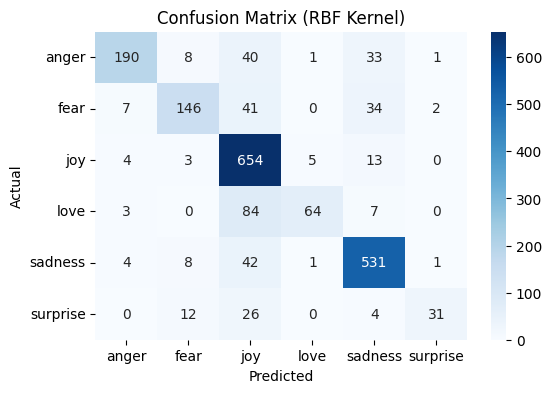

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_rbf = confusion_matrix(y_test_sub, y_pred_rbf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (RBF Kernel)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# **input testing of RBF kernel**

In [ ]:
test_sentence = "I'm feeling very anxious and nervous about tomorrow."
# Transform sentence using your existing vectorizer
X_input = vectorizer.transform([test_sentence])
pred_rbf = rbf_model.predict(X_input)
emotion_rbf = le.inverse_transform(pred_rbf)
print("🔵 RBF Kernel Prediction:", emotion_rbf[0])


🔵 RBF Kernel Prediction: fear


# **Confusion Matrix of Polynomial Kernel**

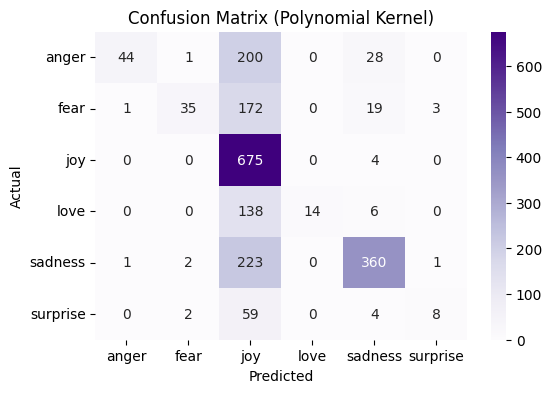

In [ ]:
cm_poly = confusion_matrix(y_test_sub, y_pred_poly)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_poly, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Polynomial Kernel)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# **Input testing of Polynomial Kernel**

In [ ]:
test_sentence = "I'm feeling very anxious and nervous about tomorrow."
X_input = vectorizer.transform([test_sentence])

pred_poly = poly_model.predict(X_input)
emotion_poly = le.inverse_transform(pred_poly)
print("🔴 Polynomial Kernel Prediction:", emotion_poly[0])


🔴 Polynomial Kernel Prediction: fear
